In [1]:
import pandas as pd
import numpy as np
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Parameterises the zone - PT stop legs
## Needs PT access and egress links

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_access_egress')

In [4]:
# Load distances to PT stops from census data
clusters = pd.read_csv(input_path + 'spatial_census_refined_FID.csv')
clusters.set_index('index', inplace=True)

In [5]:
clusters.shape

(417977, 7)

In [6]:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'

In [7]:
clusters.sample(3)

,FID,geometry,route_type,stop_name,cluster_center,weighted_dist,mean_weighted_dist
index,,,,,,,
bus_n_223060,DE112,POINT (9.003672 48.7976),bus,Leonberg Römerstraße,POINT (9.001868857967111 48.79670721592046),222.282119,5616.266506
bus_n_87010,DE218,POINT (11.828153 48.198463),bus,"Gelting, Geltinger Au",POINT (11.82177934809812 48.19279204451743),937.552624,3305.073804
bus_n_218534,DE723,POINT (8.176053 50.530945),bus,Reichenborn Ortsmitte Nrückers,POINT (8.177048954585453 50.53119002173922),113.410266,9974.836474


### Generate the average distance to the next PT stop

In [8]:
# Create a zone - distance dict
# Take the mean weighted distance
zone_type_dist = clusters.groupby(['FID', 'route_type']).agg(
    {mean_dist_col: 'mean'})#.to_dict()[mean_dist_col]

In [9]:
zone_type_dist

mean_weighted_dist
FID     route_type                             
DE111   bus                         2772.743088
        coach                       4942.656226
        rail_long_distance          8479.864860
        rail_short_distance         7514.247225
DE112   bus                         5616.266506
...                                         ...
DEG0N   rail_short_distance         5159.448391
DEG0P_1 bus                         3800.664290
        rail_short_distance        22847.910038
DEG0P_2 bus                         4306.231379
        rail_short_distance        17713.421868

[1379 rows x 1 columns]

### Alter the PT legs

In [10]:
# Split legs into access and egress
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()# name in quetzal

In [11]:
#access['distance'] = [zone_type_dist[a] for a in tuple(zip(access['a'], access['route_type']))]
#egress['distance'] = [zone_type_dist[a] for a in tuple(zip(egress['b'], egress['route_type']))]

In [12]:
# Alter the distance
route_types = clusters['route_type'].unique()
for t in route_types:
    for zone in list(sm.zones.index):
        try:
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = np.nan
for t in route_types:
    for zone in list(sm.zones.index):
        try:
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = np.nan

In [13]:
sm.zone_to_transit = access.append(egress)

In [14]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / 17 * 3.6 # in s

In [15]:
sm.zone_to_transit.sample(3)#.sort_values('time').loc[sm.zone_to_transit['direction']=='access'].head()

,a,b,direction,distance,route_type,speed,time,geometry
index,,,,,,,,
116,DE212,rail_long_node_1067,access,1649.0,rail_long_distance,9,349.200000,"LINESTRING (11.54702 48.15300, 11.55833 48.14023)"
2557,bus_n_159873,DE21L,eggress,543.0,bus,5,114.988235,"LINESTRING (11.28172 48.00623, 11.27584 48.00332)"
37,DE925,rail_long_node_599,access,7857.0,rail_long_distance,17,1663.835294,"LINESTRING (9.94358 52.09022, 9.95350 52.16063)"


In [16]:
sm.zone_to_transit.shape

(2778, 8)

In [17]:
sm.zone_to_transit.loc[sm.zone_to_transit['time'].isna()].shape

(0, 8)

In [18]:
# Ditch all legs whith erronous times
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time'].notna()]

In [19]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<3600]

In [20]:
sm.zone_to_transit.shape

(2778, 8)

direction
access     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
eggress    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

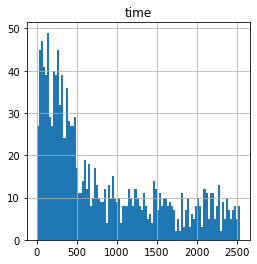

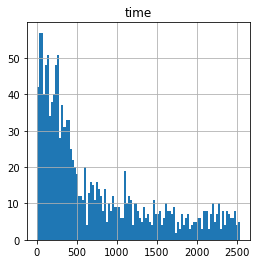

In [21]:
sm.zone_to_transit.groupby('direction').hist(column='time', bins=100, log=False, figsize=(4,4))

### Save model

In [22]:
sm.to_json(model_path + 'de_pt_access_egress',
           only_attributes=['centroids', 'footpaths', 'zone_to_transit'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]
